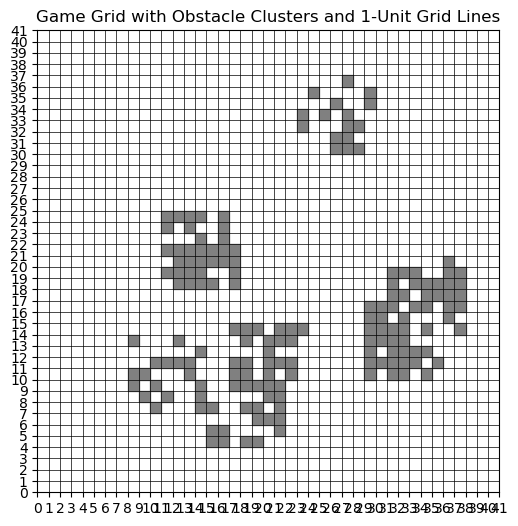

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 设置网格大小
grid_size = 41

# 障碍堆数目为5到7
num_obstacle_clusters = random.randint(5, 7)

# 每个障碍堆的障碍物数量为20到60
obstacle_cluster_sizes = [random.randint(20, 60) for _ in range(num_obstacle_clusters)]

# 创建绘图对象
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)

# 设置 x 和 y 轴的刻度，每个单位为 1
ax.set_xticks(np.arange(0, grid_size + 1, 1))
ax.set_yticks(np.arange(0, grid_size + 1, 1))

# 启用网格
ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)

# 生成障碍物堆
obstacle_positions = set()

for cluster_size in obstacle_cluster_sizes:
    # 随机生成每个障碍堆的中心点
    center_x = random.randint(5, grid_size - 5)
    center_y = random.randint(5, grid_size - 5)
    
    # 生成聚集在一起的障碍物
    for _ in range(cluster_size):
        offset_x = random.randint(-3, 3)  # 控制障碍物在中心点附近随机分布
        offset_y = random.randint(-3, 3)
        
        obstacle_x = max(0, min(center_x + offset_x, grid_size - 1))
        obstacle_y = max(0, min(center_y + offset_y, grid_size - 1))
        
        obstacle_positions.add((obstacle_x, obstacle_y))

# 绘制障碍物
for (x, y) in obstacle_positions:
    obstacle_patch = plt.Rectangle((x, y), 1, 1, color='gray')
    ax.add_patch(obstacle_patch)

# 设置标题和显示
ax.set_title('Game Grid with Obstacle Clusters and 1-Unit Grid Lines')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import time

# 定义迷宫环境
class MazeEnv:
    def __init__(self, size=8):
        self.size = size
        self.maze = np.zeros((size, size))
        self.state_size = size * size
        self.reset()

    def reset(self):
        # 随机设置起点和终点
        self.agent_pos = [0, 0]  # 初始位置
        self.goal_pos = [self.size - 1, self.size - 1]  # 终点位置
        self.maze = np.zeros((self.size, self.size))
        self.maze[self.goal_pos[0], self.goal_pos[1]] = 2  # 2代表目标
        self.steps = 0
        return self.get_state()

    def step(self, action):
        self.steps += 1
        # 定义四个方向的动作：上、下、左、右
        if action == 0:  # 向上
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == 1:  # 向下
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.size - 1)
        elif action == 2:  # 向左
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 3:  # 向右
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.size - 1)

        # 计算奖励
        reward = -0.1  # 每步的基础惩罚
        done = False

        if self.agent_pos == self.goal_pos:
            reward = 1
            done = True
        elif self.steps >= 50:  # 限制步数，避免无限循环
            done = True

        return self.get_state(), reward, done

    def get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos[0], self.agent_pos[1]] = 1  # 1代表agent的位置
        return state.flatten()

    def render(self):
        maze_copy = np.copy(self.maze)
        maze_copy[self.agent_pos[0], self.agent_pos[1]] = 1
        plt.imshow(maze_copy, cmap='hot', interpolation='nearest')
        plt.show()

# 定义DQN模型
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN智能体
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # 折扣因子
        self.epsilon = 1.0  # 探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)[0]).item()
            target_f = self.model(state)
            target_f = target_f.clone().detach()
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 可视化训练进度
def plot_rewards(episode_rewards):
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (Last 100 Episodes)')
    plt.show()

# 主程序
if __name__ == "__main__":
    env = MazeEnv()
    state_size = env.state_size
    action_size = 4  # 上、下、左、右
    agent = DQNAgent(state_size, action_size)
    episodes = 1000
    batch_size = 32

    episode_rewards = []
    avg_rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(50):
            env.render()  # 可视化每一步
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(f"Episode {e+1}/{episodes}, Reward: {total_reward}")
                break

        episode_rewards.append(total_reward)

        # 训练模型
        agent.replay(batch_size)

        # 每100次统计一次平均reward
        if (e + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)
            print(f"Episode {e+1}: Average Reward in last 100 episodes: {avg_reward}")

    # 绘制平均奖励折线图
    plot_rewards(avg_rewards)
